In [1]:
# Import the required libraies

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
from sklearn.model_selection import GridSearchCV
from scipy.ndimage import label
import moviepy.editor as mp

In [2]:
# Read and load the vehicle images

vehicle_path = os.listdir("vehicles/")
vehicle = []
for path in vehicle_path:
    image_path = "vehicles/" + path
    image_names = os.listdir(image_path)
    for name in image_names:
        img = cv2.imread(image_path + "/" + name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        vehicle.append(img)

In [3]:
# Read and load the non vehicle images
non_vehicle_path = os.listdir("non-vehicles/")
non_vehicle = []
for path in non_vehicle_path:
    image_path = "non-vehicles/" + path
    image_names = os.listdir(image_path)
    for name in image_names:
        img = cv2.imread(image_path + "/" + name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        non_vehicle.append(img)

In [4]:
# Data set information

print("number of vehicle images is: " + str(len(vehicle)))
print("number of non vehicle images is: " + str(len(non_vehicle)))
print("image shape is: " + str(vehicle[0].shape))

number of vehicle images is: 8792
number of non vehicle images is: 8968
image shape is: (64, 64, 3)


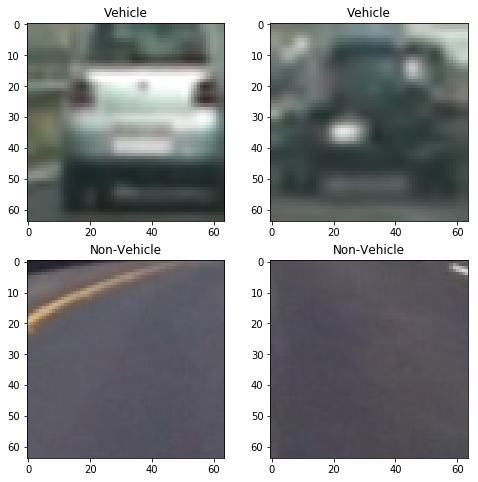

In [5]:
# Plot examples of the vehicle and non-vehicle data set

fig, axs = plt.subplots(2,2, figsize = (8,8))


for i in range(2):
    if i ==0:
        data_set = vehicle
        tt = "Vehicle"
    else:
        data_set = non_vehicle
        tt = "Non-Vehicle"
        
    for j in range(2):
        axs[i][j].imshow(data_set[j+ 100])
        axs[i][j].set_title(tt)
        



fig.savefig("output_images/example.jpg", bbox_inches = "tight")

In [6]:
# Color histogram function

def color_hist(img, nbins = 32, bins_range = (0,256)):
    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

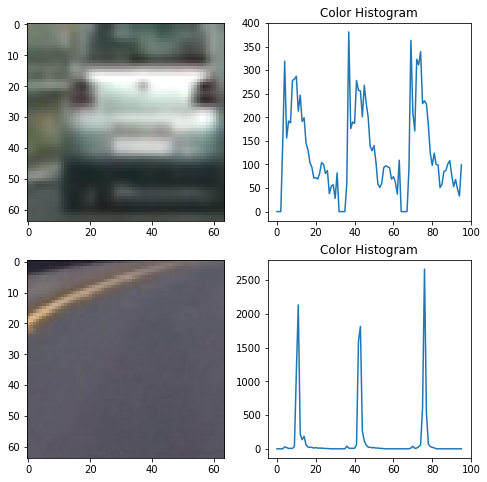

In [7]:
# Plot examples of the vehicle and non-vehicle data set

fig, axs = plt.subplots(2,2, figsize = (8,8))


for i in range(2):
    if i ==0:
        data_set = vehicle
    else:
        data_set = non_vehicle
        
    feature = color_hist(data_set[100])
    for j in range(2):
        if j==0:
            axs[i][j].imshow(data_set[100])
        else:
            axs[i][j].plot(feature)
            axs[i][j].set_title("Color Histogram")
            
            
fig.savefig("output_images/colorhist.jpg", bbox_inches = "tight")  

In [8]:
def bin_spatial(img, size =(32,32)):
    
    bin_features = cv2.resize(img, size).ravel()
    
    return bin_features

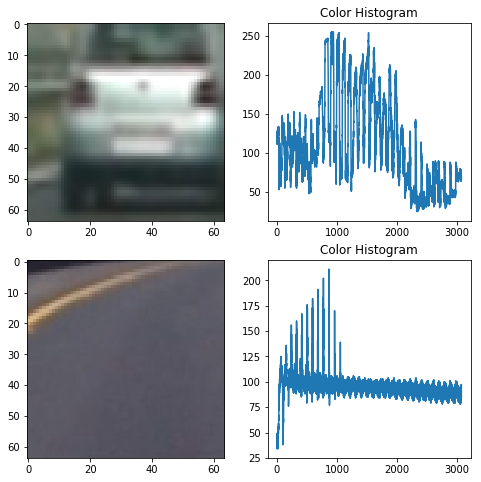

In [9]:
# Plot examples of the vehicle and non-vehicle data set

fig, axs = plt.subplots(2,2, figsize = (8,8))


for i in range(2):
    if i ==0:
        data_set = vehicle
    else:
        data_set = non_vehicle
        
    feature = bin_spatial(data_set[100])
    for j in range(2):
        if j==0:
            axs[i][j].imshow(data_set[100])
        else:
            axs[i][j].plot(feature)
            axs[i][j].set_title("Color Histogram")
            
            
fig.savefig("output_images/binspatial.jpg", bbox_inches = "tight")

In [10]:
# Histogram of Oriented Gradient (HOG) Features

def get_hog_features(single_channel, orient, pix_per_cell, cell_per_block, vis = True, feature_vec = True):
    
    result = hog(single_channel, orientations=orient, pixels_per_cell = (pix_per_cell,pix_per_cell),
                cells_per_block = (cell_per_block,cell_per_block),
                transform_sqrt = False,
                visualise = vis, feature_vector = feature_vec)
    
    if vis:
        hog_image = result[1]
        hog_features = result[0]
        
        return hog_features, hog_image
    else:
        return result

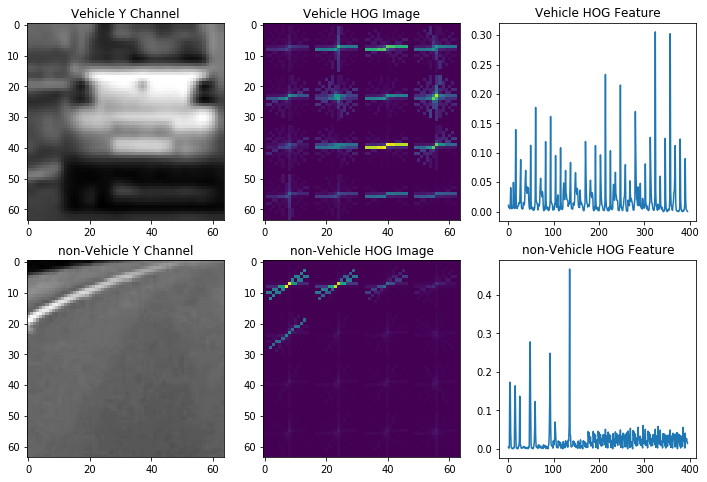

In [11]:
# HOG image for vehicle and non-vehicle image

fig, axs = plt.subplots(2,3, figsize = (12,8))



for i in range(len(axs)):
    if i==0:
        img = vehicle[100]
        tt = "Vehicle"
    else:
        img = non_vehicle[100]
        tt = "non-Vehicle"
    YUV_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    hog_features, hog_image = get_hog_features(YUV_img[:,:,0], orient= 11, pix_per_cell=16, cell_per_block= 2, vis=True, feature_vec=True)
        
    for j in range(len(axs[0])):
        if j == 0:
            axs[i][j].imshow(YUV_img[:,:,0], cmap = "gray")
            axs[i][j].set_title(tt+ " Y Channel")
        elif j == 1:
            axs[i][j].imshow(hog_image)
            axs[i][j].set_title(tt+" HOG Image")
        
        else:
            axs[i][j].plot(hog_features)
            axs[i][j].set_title(tt+" HOG Feature")
fig.savefig("output_images/Hog.jpg", bbox_inches = "tight")

In [12]:
# Combines all the different features into a single feature vector

def feature_extraction(img, Cspace = "YUV"):
    
    
    if Cspace != 'RGB':
        
        if Cspace == 'HSV':
            Cspace_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif Cspace == 'LUV':
            Cspace_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif Cspace == 'HLS':
            Cspace_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif Cspace == 'YUV':
            Cspace_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif Cspace == 'YCrCb':
                Cspace_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        Cspace_img = np.copy(img)
        
    single_channel1 = Cspace_img[:,:,0]
    single_channel2 = Cspace_img[:,:,1]
    single_channel3 = Cspace_img[:,:,2]
    
    
    feature_vec1 = color_hist(Cspace_img, nbins = 32, bins_range = (0,256))
    feature_vec2 = bin_spatial(Cspace_img, size =(32,32))
    
    feature_vec3 = get_hog_features(single_channel1, orient= 11, pix_per_cell=16, cell_per_block= 2, vis=False, feature_vec=True)
    feature_vec4 = get_hog_features(single_channel2, orient= 11, pix_per_cell=16, cell_per_block= 2, vis=False, feature_vec=True)
    feature_vec5 = get_hog_features(single_channel3, orient= 11, pix_per_cell=16, cell_per_block= 2, vis=False, feature_vec=True)
    
    feature_vector = np.concatenate((feature_vec1, feature_vec2, feature_vec3, feature_vec4, feature_vec5))
    
    return feature_vector

In [13]:
# Get the feature vectors for all the vehicle and non-vehicle images

def get_data_feature(vehicle_list, non_vehicle_list, Cspace = "YUV"):
    
    Data_feature = []
    
    for image in vehicle_list:
        feature = feature_extraction(image, Cspace)
        Data_feature.append(feature)
    
    for image in non_vehicle_list:
        feature = feature_extraction(image, Cspace)
        Data_feature.append(feature)
        
    X = np.vstack(Data_feature).astype(np.float64) 
    
    return X

In [14]:
# Generate labels for the data set

def Generate_label(vehicle_list, non_vehicle_list):
    
    non_vehicle_labels = np.zeros(len(non_vehicle_list))
    vehicle_labels = np.ones(len(vehicle_list))
    
    Y = np.hstack((vehicle_labels, non_vehicle_labels))
    
    return Y

In [15]:
# Spilit the data to training set and test set
X  = get_data_feature(vehicle, non_vehicle, Cspace='YUV')
Y = Generate_label(vehicle, non_vehicle)

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = rand_state)

In [16]:
del vehicle
del non_vehicle

print("number of training data points: "  + str(len(y_train)))
print("number of test data points: " + str(len(y_test)))

number of training data points: 14208
number of test data points: 3552


In [17]:
# Normalize the data
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [18]:
# Train a Support Vector Machine (SVM)
svc = LinearSVC()

t0 = time.time()
svc.fit(X_train, y_train)
t1 = time.time()

delta_t =t1 - t0
print(delta_t)

10.955075979232788


In [19]:
del X_train
del y_train

print(svc.score(X_test,y_test))

0.991835585586


In [20]:
# Sliding window function
def slide_window(img, x_start_stop = [None,None], y_start_stop = [None,None], xy_window = (64,64),
                xy_overlap = (0.5,0.5)):
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
           
        
    xspan = x_start_stop[1] - x_start_stop[0] 
    yspan = y_start_stop[1] - y_start_stop[0]
    

    
    # Compute the step size for the window
    stride_x = np.int(xy_window[0]*(1 - xy_overlap[0]))
    stride_y = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of steps
    bufferx = np.int(xy_window[0]*(xy_overlap[0]))
    buffery = np.int(xy_window[1]*(xy_overlap[1]))
    
    nx = np.int((xspan - bufferx)/stride_x)
    ny = np.int((yspan - buffery)/stride_y)
    
    # Initialize the window size:
    window_list = []
    
    for ys in range(ny):    
        for xs in range(nx):
            startx = xs*stride_x + x_start_stop[0]
            endx = startx + xy_window[0]
            
            starty = ys*stride_y + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx,starty),(endx,endy)))
            
    return window_list

In [21]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [22]:
def generate_windows(img, window_sizes, region_bounds,overlaps):
    final_windows = []
    for i in range(len(window_sizes)):
        windows = slide_window(img,
                    x_start_stop = [None, None],
                    y_start_stop = region_bounds[i], 
                    xy_window = (np.int(window_sizes[i][0]*64),np.int(window_sizes[i][1]*64)),
                    xy_overlap = overlaps[i])
        
        final_windows = final_windows + windows
        
    return final_windows  

166


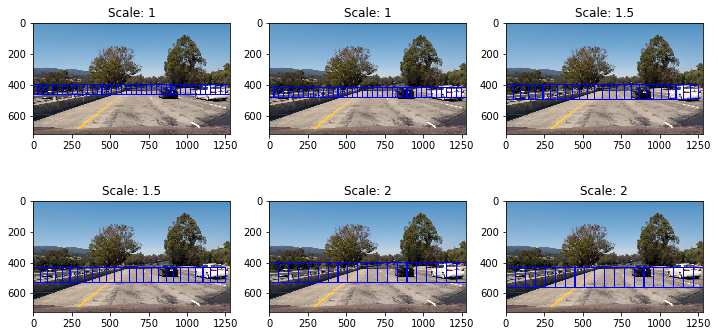

In [23]:
test_image = cv2.imread("test_images/test1.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(2,3, figsize = (12,6))
axs = axs.ravel()


window_sizes = [(1,1),(1,1),(1.5,1.5),(1.5,1.5),(2,2),(2,2)]
region_bounds = [[400,464],[416,480],[400,496],[432,528],[400,528],[432,560]]
overlaps = [(0.5,0.75),(0.5,0.75),(0.5,0.75),(0.5,0.75),(0.5,0.75),(0.5,0.75)]
all_windows = generate_windows(test_image,window_sizes, region_bounds, overlaps)
print(len(all_windows))

for i in range(6):

    all_windows = generate_windows(test_image,window_sizes[i:i+1], region_bounds[i:i+1], overlaps[i:i+1])
    box = draw_boxes(test_image, all_windows)
    plt.figure()
    axs[i].imshow(box)
    axs[i].set_title("Scale: " + str(window_sizes[i][0]))
    
fig.savefig("output_images/sliding_window.jpg", bbox_inches = "tight")

In [24]:
def filter_windows(img, windows, classifier, normalizer, confidence):
    
    vehicle_windows = []
    
    for window in windows:

        sub_region = img[window[0][1]:window[1][1],window[0][0]:window[1][0]]
        
        if sub_region.shape !=(64,64):
            sub_region = cv2.resize(sub_region, (64,64))
        
        feature_vector = feature_extraction(sub_region, Cspace = 'YUV')
        norm_feature = normalizer.transform([feature_vector])
        
        prediction = classifier.predict(norm_feature)
        
        # Classification Confidence
        y = classifier.decision_function(norm_feature)
        w_norm = np.linalg.norm(svc.coef_)
        
        test_dist = y / w_norm
        
        if (prediction ==1 and test_dist > confidence):
            vehicle_windows.append(window)
    
    return vehicle_windows

In [25]:
def add_heat(heatmap, box_list):
    
    for box in box_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]+=1
        
    return heatmap

In [26]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

In [27]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [72]:
def car_detection(img, classifier, normalizer):
    
    window_sizes = [(1,1),(1,1),(1.5,1.5),(1.5,1.5),(2,2),(2,2)]
    region_bounds = [[400,464],[416,480],[400,496],[432,528],[400,528],[432,560]]
    overlaps = [(0.5,0.75),(0.5,0.75),(0.5,0.75),(0.5,0.75),(0.5,0.75),(0.5,0.75)]
    
    all_windows = generate_windows(img,window_sizes, region_bounds, overlaps)
    vehicle_windows = filter_windows(img,all_windows,classifier,normalizer, 0.35)
    
    heatmap = np.zeros_like(img[:,:,0])
    
    heatmap = add_heat(heatmap,vehicle_windows)
    heatmap = apply_threshold(heatmap,2)
    
    labels = label(heatmap)
    
    output = draw_labeled_bboxes(img, labels)
    
    return output, vehicle_windows

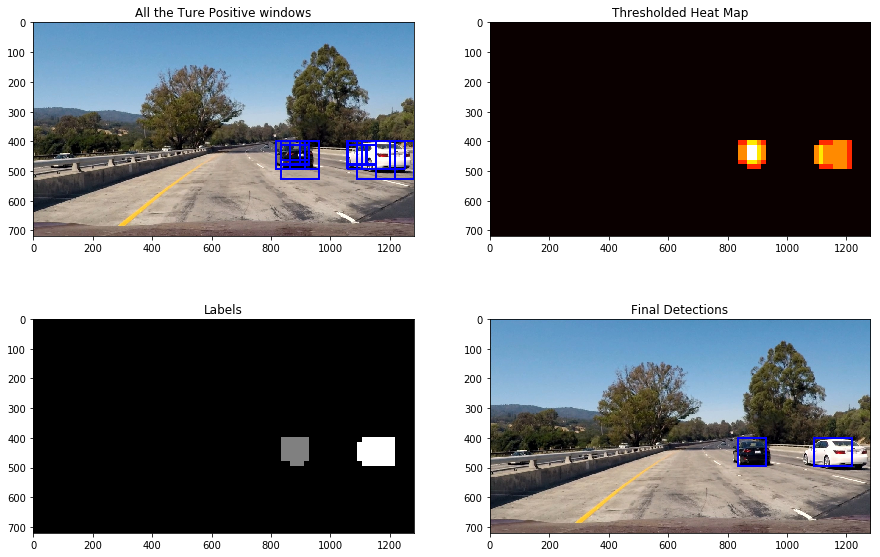

In [73]:
test_image = cv2.imread("test_images/test1.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(2,2, figsize =(15,10))
axs = axs.ravel()

window_sizes = [(1,1),(1,1),(1.5,1.5),(1.5,1.5),(2,2),(2,2)]
region_bounds = [[400,464],[416,480],[400,496],[432,528],[400,528],[432,560]]
overlaps = [(0.5,0.75),(0.5,0.75),(0.5,0.75),(0.5,0.75),(0.5,0.75),(0.5,0.75)]
    
all_windows = generate_windows(test_image,window_sizes, region_bounds, overlaps)

vehicle_windows = filter_windows(test_image, all_windows,svc, X_scaler, 0.4)

detections = draw_boxes(test_image, vehicle_windows)

heatmap = np.zeros_like(test_image[:,:,0])
    
heatmap = add_heat(heatmap,vehicle_windows)

heatmap = apply_threshold(heatmap,2)

labels = label(heatmap)

final_detection = draw_labeled_bboxes(test_image, labels)


axs[0].imshow(detections)
axs[0].set_title('All the Ture Positive windows')

axs[1].imshow(heatmap, cmap ='hot')
axs[1].set_title('Thresholded Heat Map')


axs[2].imshow(labels[0], cmap ='gray')
axs[2].set_title('Labels')

axs[3].imshow(final_detection)
axs[3].set_title('Final Detections')

fig.savefig("output_images/detection_process.jpg", bbox_inches = 'tight')

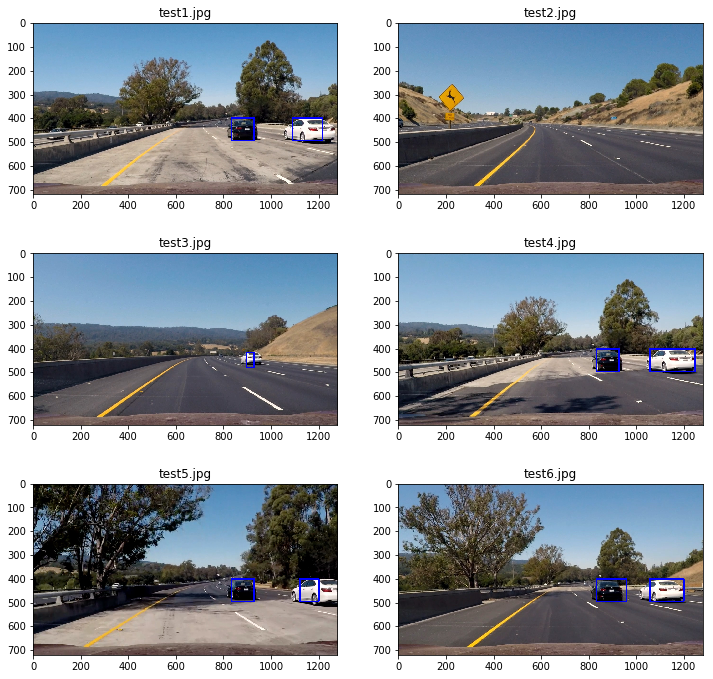

In [74]:
# Vehicle Detection on Test Images:
fig, axs = plt.subplots(3,2, figsize = (12,12))
axs = axs.ravel()

test_path = "test_images/"
image_names = os.listdir(test_path)

counter = 0

for image in image_names:

    test_image = cv2.imread(test_path + image)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
    detection,_ = car_detection(test_image, svc, X_scaler)
    axs[counter].imshow(detection)
    axs[counter].set_title(image)
    counter+=1
fig.savefig("output_images/final_detection.jpg", bbox_inches = "tight")

In [44]:
# Vehicle class to track the detections in several frames
class Vehicle_Tracker():
    
    def __init__(self):
        self.detection = []
        
    def add_detection(self,bbox_list):
        self.detection.append(bbox_list)
        
        if len(self.detection) > 15:
            
            self.detection = self.detection[len(self.detection)-15:]

In [75]:
# FINAL PIPELINE FOR LANE DETECTION IN VIDEO STREAM#

def VIDEO_PROCESS(cap, classifier, normalizer,Video_name):
    
    Car = Vehicle_Tracker()
    
    # Video infomration    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # output video spec
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(Video_name, fourcc, fps,(frameWidth,frameHight))

    for i in range(frameCount):
        
        if i%10== 0:
            print("Processing frame number:" + str(i))
        
        ret, img = cap.read()

        
        if ret == True:
            frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        
            _,frame_windows = car_detection(frame, classifier, normalizer)
            
            if len(frame_windows) > 0:
                Car.add_detection(frame_windows)
            
            heatmap_frame = np.zeros_like(frame[:,:,0])
            
            for bboxes in Car.detection:
                heatmap_frame = add_heat(heatmap_frame, bboxes)
            
            heatmap_frame = apply_threshold(heatmap_frame, 1 + len(Car.detection)//2.0)
            
            labels = label(heatmap_frame)
            
            annotated_frame = draw_labeled_bboxes(img, labels)
            
            out.write(annotated_frame)
                
        else:
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [76]:
# Process the test video
cap = cv2.VideoCapture("test_video.mp4")
VIDEO_PROCESS(cap, svc, X_scaler, "test_result.avi")

Processing frame number:0
Processing frame number:10
Processing frame number:20
Processing frame number:30


In [77]:
# Conver the result to gif format
clip = (mp.VideoFileClip("test_result.avi").resize(0.5))
clip.write_gif("test_result.gif")


[MoviePy] Building file test_result.gif with imageio


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [00:03<00:00,  8.30it/s]


In [ ]:
# Process the video
cap = cv2.VideoCapture("project_video.mp4")
VIDEO_PROCESS(cap, svc, X_scaler, "Final_result.avi")

In [ ]:
# Conver the result to gif format
clip = (mp.VideoFileClip("Final_result.avi").resize(0.25))
clip.write_gif("Final.gif")